## 导包和加载模型

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
epsilons = [0, 1/255, 10/255, 20/255, 50/255]
my_epsilon = 50/255
pretrained_model = "./param.pth"

n_epochs = 5 #训练次数
batch_size_train = 256 #训练的 batch_size
learning_rate = 0.001 # 学习率

In [3]:
torch.cuda.is_available()

True

In [4]:
#net
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # 卷积层1
        self.conv1 = nn.Conv2d(in_channels = 1 , out_channels = 32, kernel_size = 5, stride = 1, padding = 0 )
        # 对每个通道的数据进行归一化
        self.batch1 = nn.BatchNorm2d(32)
        # ReLu激活函数
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels =32 , out_channels = 32, kernel_size = 5, stride = 1, padding = 0 )
        self.batch2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        # 最大池化
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        # Dropout防止过拟合
        self.conv1_drop = nn.Dropout(0.25)

        # 卷积层2
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 0 )
        self.batch3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 0 )
        self.batch4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2_drop = nn.Dropout(0.25)

        # 全连接层1
        
        self.fc1 = nn.Linear(576,256)
        self.fc1_relu = nn.ReLU()
        self.dp1 = nn.Dropout(0.5)
        
        # 全连接层2
        self.fc2 = nn.Linear(256,10)
                
    def forward(self, x):
        # 卷积层1的前向计算
        # print(out.shape)
        # (batch_size,1,28,28)

        out = self.conv1(x)
        out = self.relu1(out)
        out = self.batch1(out)
        # print(out.shape)
        # (batch_size,32,24,24)

        out = self.conv2(out)
        out = self.relu2(out)
        out = self.batch2(out)
        # print(out.shape)
        # (batch_size,32,20,20)

        out = self.maxpool1(out)
        out = self.conv1_drop(out)
        # print(out.shape)
        # (batch_size,32,10,10)

        # 卷积层2的前向计算
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.batch3(out)
        # print(out.shape)        
        # (batch_size,64,8,8)

        out = self.conv4(out)
        out = self.relu4(out)
        out = self.batch4(out)   
        # print(out.shape)
        # (batch_size,64,6,6)

        out = self.maxpool2(out)
        out = self.conv2_drop(out)
        # print(out.shape)
        # (batch_size,64,3,3)

        # Flatten拉平操作
        out = out.view(out.size(0),-1)
        # print(out.shape)
        # (batch_size,576)
        
        # 全连接层的前向计算
        out = self.fc1(out)
        out = self.fc1_relu(out)
        out = self.dp1(out)
        # print(out.shape)
        # (batch_size,256)

        out = self.fc2(out)
        # print(out.shape)
        # (batch_size,10)

        return F.log_softmax(out,dim = 1)

In [5]:
# MNIST Test dataset and dataloader declaration
#导入训练集并增强数据
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist/', train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.RandomAffine(degrees = 10,translate=(0.1, 0.1)),
                                  #  transforms.RandomRotation((-10,10)),#将图片随机旋转（-10,10）度
                                   transforms.ToTensor(),# 将PIL图片或者numpy.ndarray转成Tensor类型
                                   transforms.Normalize((0.1307,), (0.3081,))])
                              ),
    batch_size=batch_size_train, shuffle=True, num_workers=4, pin_memory=True) # shuffle如果为true,每个训练epoch后，会将数据顺序打乱
#导入测试集
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist/', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=1, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Initialize the network
model = CNNModel().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu')) # 加载模型的参数
# model = torch.load(pretrained_model)  # 加载整个模型及其参数

# Set the model in evaluation mode. In this case this is for the Dropout layers
# model.eval()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    # perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # 在(0,1)用torch.clamp会和前面DataLoader()中的Normalize((0.1307,), (0.3081,))有冲突，干脆不用

    # Return the perturbed image
    return perturbed_image

## 用训练集进行防御训练

In [8]:
# 定义训练函数
def train(epoch, epsilon):
    
    model.train() # 将网络设为 training 模式
    train_correct = 0
    # 对一组 batch 
    for batch_idx, (data, target) in enumerate(train_loader): 
        # 先对样本图片攻击，再将攻击过的(adv_data, target)送入模型预测并训练
        data, target = data.to(device), target.to(device)
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        # 训练集的每个样本都要攻击

        # 计算损失
        loss = F.nll_loss(output, target)

        # 归零梯度
        # model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # 防御训练
        # 1-将梯度归零
        optimizer.zero_grad()
        
        # 2-传入一个batch的图像，并前向计算
        # data.to(device)把图片放入GPU中计算
        output = model(perturbed_data.to(device))
        
        # 3-计算损失 损失函数采用nll_lose()
        loss = F.nll_loss(output, target.to(device))
        
        # 4-反向传播
        loss.backward()
        
        # 5-优化参数
        optimizer.step()
        
        train_pred = output.data.max(dim=1, keepdim=True)[1] # 取 output 里最大的那个类别, 
             # dim = 1表示取每行的最大值，[1]表示取最大值的index，而不去最大值本身[0]    

        train_correct += train_pred.eq(target.data.view_as(train_pred).to(device)).sum() # 比较并求正确分类的个数
        #打印以下信息：第几个epoch，第几张图像， 总训练图像数, 完成百分比，目前的loss
        print('\r 第 {} 次 Defense Train Epoch: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()),end = '')
    
    train_acc = train_correct / len(train_loader.dataset)
    train_acces.append(train_acc.cpu().numpy().tolist())
    print('\tTrain Accuracy:{:.2f}%'.format(100. * train_acc))


## 用测试集进行对抗攻击

记得将model设置为 **eval()** 模式

In [9]:
def test( model, device, test_loader, epsilon ):
    #!!!!!!!!!!!
    model.eval()
    #!!!!!!!!!!!
    global origWrong        
    # Accuracy counter
    correct = 0
    adv_examples = []

    tag = [0] * 10

    # Loop over all examples in test set
    for batch_idx, (data, target) in enumerate(test_loader):

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True
        
        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # 如果模型最初预测就是错的，就不再攻击这个样本了
        if init_pred.item() != target.item():
            origWrong += 1
            continue

        # 计算损失
        loss = F.nll_loss(output, target)

        # 归零梯度
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        print('\r\t Attack Epoch: [{}/{} ({:.0f}%)]\t'.format(
            (batch_idx + 1) * len(data), len(test_loader.dataset),100. * batch_idx / len(test_loader)),end = '')

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # 由于我们的目的是防御，所以这里就展示一些防御成功/攻击失败的例子
            if len(adv_examples) < 20:
                if tag[init_pred.item()] == 0:
                    tag[init_pred.item()] = 1
                    adv_ex = data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), -1, adv_ex) )
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        # else:
        #     # 保存结果图以便后续可视化
        #     if len(adv_examples) < 20:
        #         if tag[init_pred.item()] == 0:
        #             tag[init_pred.item()] = 1
        #             adv_ex = data.squeeze().detach().cpu().numpy()
        #             adv_examples.append( (init_pred.item(), -1, adv_ex) )
        #             adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        #             adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # 计算当前epsilon的准确率
    final_acc = correct/float(len(test_loader))
    print("\tTest Accuracy = {} / {} = {}".format(correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [10]:
test_acces = []
examples = []
train_acces = []
origWrong = 0 # 模型在未被攻击的原测试集上预测错误的个数

for epoch in range(1, n_epochs + 1):
    train(epoch, my_epsilon)

# Run test for my epsilon
print("Epsilons = {:.3f}:".format(my_epsilon))
acc, ex = test(model, device, test_loader, my_epsilon)
test_acces.append(acc)
examples.append(ex)
print("OriginalWrongNums:{}".format(origWrong))

 第 1 次 Defense Train Epoch: [22560/60000 (100%)]	Loss: 0.171495	Train Accuracy:94.64%
 第 2 次 Defense Train Epoch: [22560/60000 (100%)]	Loss: 0.050993	Train Accuracy:95.86%
 第 3 次 Defense Train Epoch: [22560/60000 (100%)]	Loss: 0.076417	Train Accuracy:96.38%
 第 4 次 Defense Train Epoch: [22560/60000 (100%)]	Loss: 0.145521	Train Accuracy:96.72%
 第 5 次 Defense Train Epoch: [22560/60000 (100%)]	Loss: 0.076743	Train Accuracy:96.91%
Epsilons = 0.196:
	 Attack Epoch: [10000/10000 (100%)]		Test Accuracy = 9801 / 10000 = 0.9801
OriginalWrongNums:43


## 由于我们的目的是防御，所以这里就展示一些防御成功/攻击失败的例子

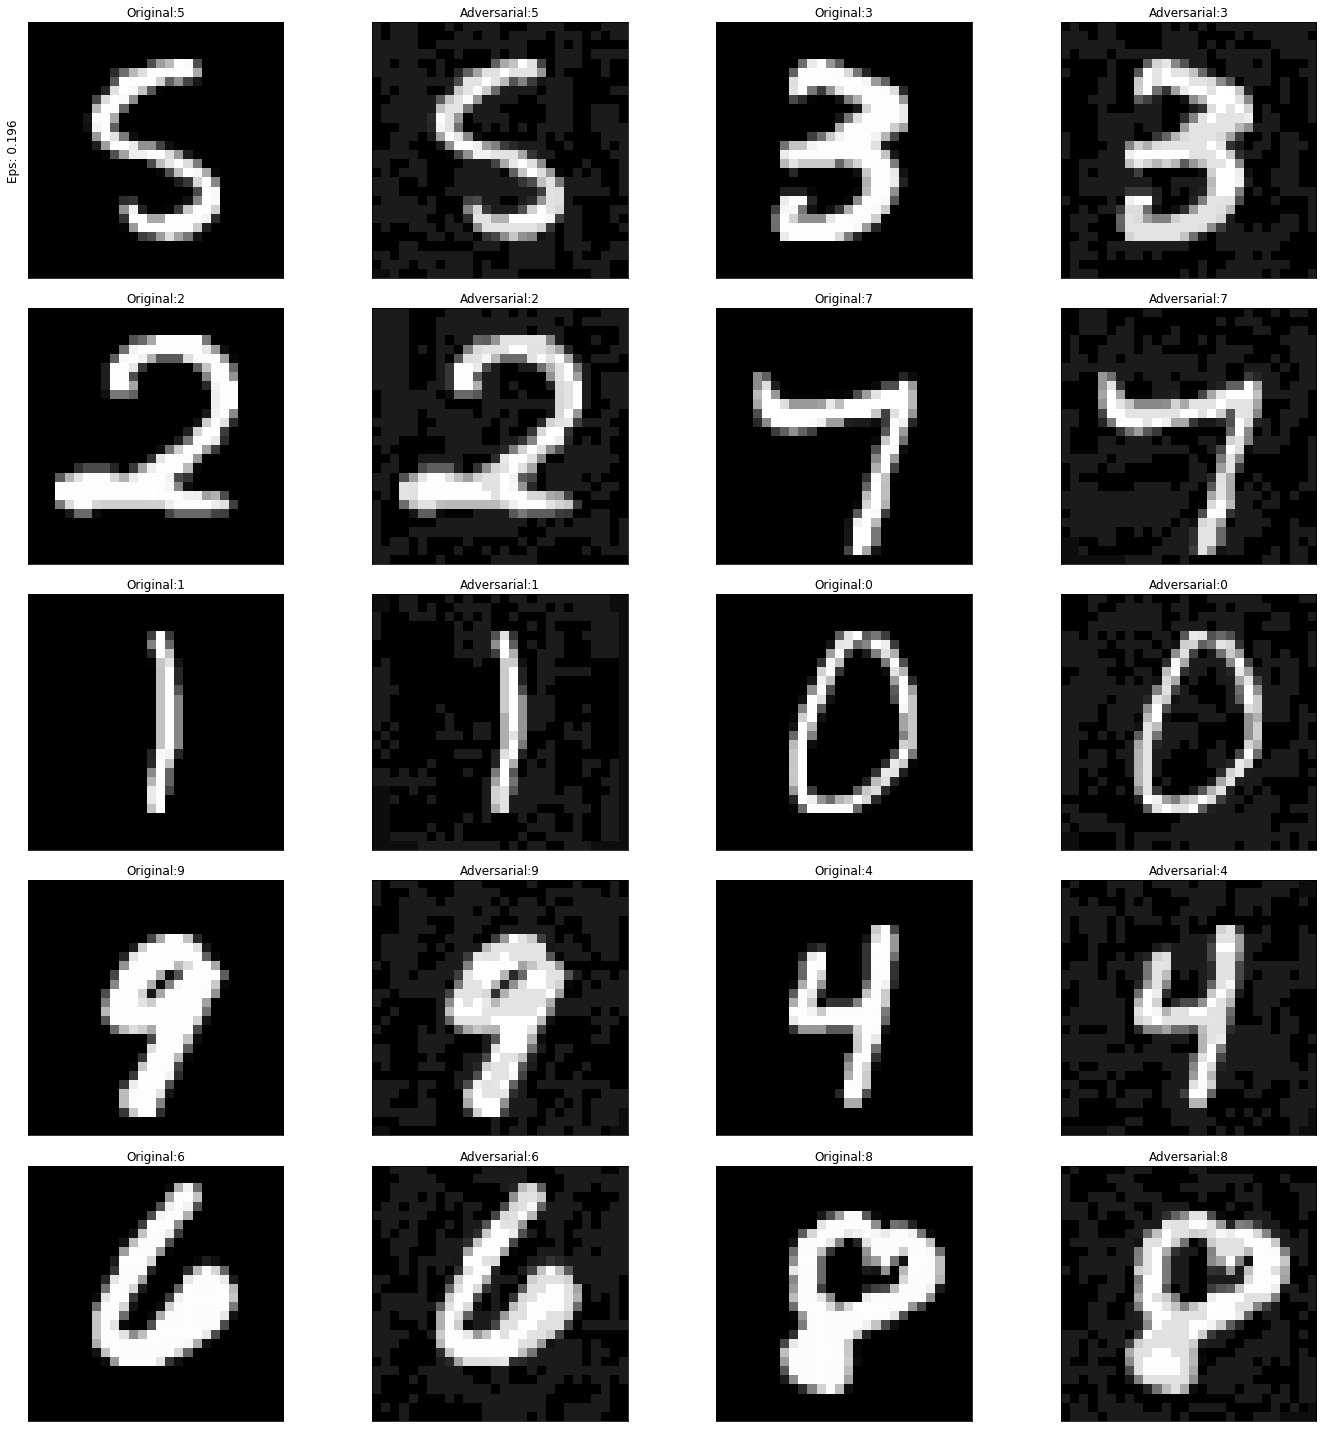

In [11]:
# Plot several examples of adversarial samples at each epsilon
cnt = 1
plt.figure(figsize=(20,20))

for j in range(len(examples[0])):
    if j == 0:
        while cnt%10 != 1:
            cnt+=1
    plt.subplot(5,4,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    if j == 0:
        plt.ylabel("Eps: {:.3f}".format(epsilons[4]), fontsize=12)
    orig,adv,ex = examples[0][j]
    if j%2 == 0:
        plt.title("Original:{}".format(orig))
    else:
        plt.title("Adversarial:{}".format(adv))
    plt.imshow(ex, cmap="gray")
    cnt += 1
plt.tight_layout()
plt.show()

- epsilons = [50/255]时，**非定向攻击失败、成功防御**的部分样本图已经展示如上

In [12]:
test_acces

[0.9801]

## 攻击成功率计算

按照$$攻击成功率=成功次数÷攻击次数$$的公式

由于只攻击了**原模型能够正确预测**的样本，即Epsilon=0时正确的个数，故 **攻击次数**=9952（即每张样本图攻击一次）

Epsilon=50/255取值下，**成功次数**为：$$9952-9801=151$$

故成功率为：$$151/9952≈0.015172829581993569=1.52\%$$

在原有的模型的基础上，再采用对抗训练方式进行防御，训练的轮数epoch=5，batch_size=256

攻击成功率从非定向攻击中的**30.12%下降到了1.52%**

模型预测准确率从**69.54%上升到了98.01%**

``对抗训练防御的效果是十分显著的``

## 一些思考

至于为什么模型的准确率只有98.01%，而我最初的模型准确率可以达到99%+

- 一方面，我只训练了**5个epoch**

- 另一方面，我想是因为我在进行对抗训练时是**直接在原有的模型的基础上进行进一步训练**的，而非针对经过FGSM攻击的样本 重新训练新的模型

而**测试时使用的测试集全部是经过FGSM攻击的样本**，没有直接将原本的测试集用于测试，所以模型的表现一般

（这也是为什么 **模型在测试集上的表现要好于在训练集上的表现** 的原因）

****

另外，我原本以为，`将原本的模型针对被攻击后的样本图片进行对抗训练后，模型对于正常图片的预测能力会下降`

但当我统计模型对正常测试集图片预测错误的个数（即OriginalWrongNums）时，在上面的展示中，OriginalWrongNums=43，即在新模型中只有43张原图会被错误预测

而对于未经过对抗训练的模型这个数字是10000-9952=48>43，也就是说**经过对抗样本的训练后，模型对原本干净的样本的预测能力也提高了**，这一点和我最开始的想法相反

思考后个人认为原因是是：

- 一方面又经过了5个epoch训练

- 另一方面对训练集样本的FGSM攻击也可以视作一种**数据增强**操作，导致模型的鲁棒性反而提高了

****

## 一些尝试

### epoch=50

后续尝试训练50个epoch，结果如下，模型的准确率可以达到图中所示的**99.13%**

可以发现增加训练的轮数之后，准确率还是能提上去的

![epoch=50](https://img-blog.csdnimg.cn/e69937af3e634d55907aa5560b656914.png)

****

### 重新训练新的模型

另一方面，我认为针对经过FGSM攻击的样本**重新训练新的模型**，尽管可能可以提高模型在被攻击后的测试集上的表现

但对于干净样本的预测能力就会下降，没有实际意义。``不能为了提高防御效果而降低了对正常样本的预测能力``。

而且比较花时间，就不再尝试